# TODOs

In [171]:
from IPython.display import display, Markdown

display(Markdown('TODO.md'))

# Stuff to be done

- [x] Initialize Jupyter notebook
- [x] Perform EDA on metrics
- [ ] Evaluate possible ML models
- [ ] Add ML pipeline for GridSearch/RandomSearch sckit-learn

# Design Pattern Recognition with Software Metrics

## Library/Package Imports
All required modules should be in the next cell to avoid scattered imports

In [154]:
# Ignore missing imports warnings in vs code
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from typing import Callable
import ipywidgets as widgets
from IPython.display import display, HTML
from typing import Optional

In [156]:
#Common utility functions

from typing import Any


def get_metric_columns():
    return ['NOF', 'NSF', 'NOM', 'NSM', 'NOAM', 'NORM', 'NOPC', 'NOOF', 'NCOF']

def generate_subplot(df: pd.DataFrame, plot_func: Callable[[pd.DataFrame, str], go.Figure], subplot_width: int = 600, subplot_height: int = 2400) -> go.Figure:
    metric_columns = get_metric_columns()
    subplots = make_subplots(len(metric_columns), subplot_titles=metric_columns)
    for i, metric in enumerate(metric_columns):
        figure = plot_func(df, metric)
        subplots.add_trace(figure, row=i+1, col=1)
    subplots['layout'].update(height=subplot_height, width=subplot_width)
    return subplots

def generate_selectable_graph_for_metrircs(df: pd.DataFrame, initial_plot_func: Callable[[], go.Figure], update_func: Callable[[go.Figure, pd.DataFrame, str], None], y_label: Optional[str] = None):
    metric_dropdown = widgets.Dropdown(options=get_metric_columns())
    fig = go.FigureWidget(initial_plot_func())

    def on_metric_changed(change):
        metric = change['new']
        with fig.batch_update():
            figure =  fig.data[0]
            update_func(figure, df, metric)
            figure['name'] = metric
            label = y_label if y_label else ' '
            fig.update_layout(title=metric, bargap = 0.5, xaxis_title=metric, yaxis_title=label)

    metric_dropdown.observe(on_metric_changed, names='value')
    display(widgets.VBox([metric_dropdown, fig]))

def filter_extended_projects(df: pd.DataFrame):
    return df[~df['project'].str.contains('DrJava')]

## Generation of metrics

If the metrics are not yet generated, the following steps are required:

1. Make sure that `source_files.zip` is located in the current directory. The archive contains the actual zipped source code of the projects in [P-MArT](https://www.ptidej.net/tools/designpatterns/) and `pmart.xml` with descriptions of the micro architectures
2. Create a new virtual Python environment with `python -m venv .` in the current directory if not yet done
3. Activate the virtual environment ([refer here for the actual command to run](https://docs.python.org/3/library/venv.html#how-venvs-work))
4. Execute `python3 preprocess_source_files.py` to extract the source files from `source_files.zip` and move the source files described in `pmart.xml` into `dataset` directory. For more information run `python3 preprocess_source_files.py -h`.
    - Source files are structured as `<dataset_dir>/<design_pattern/micro_architecture_<id>`
    - Each micro architecture directory contains the following files:
        - `roles.csv`: Roles, entity names and role kind as described in `pmart.xml`
        - `projects.txt`: From which project the source files come from
        - The source files to be evaluated
5. Execute `python3 generate_source_file_metrics.py` to generate `metrics.csv`. For more information run `python3 generate_source_file_metrics.py`.

**NOTE**: As the projects in this dataset are old and not all projects listed in P-MaRT are not accessible, some source files and their entries in `metrics` may be missing.

## Overview about `metrics.csv`

In order to detect applied Gang Of Four design patterns in source code with machine learning strategies, we first need to transform the source file into a numerical representation that can be understood by a machine learning model.
This approach aims to solve this by generating numerical characteristics for each source file in the context of the regarded micro architecture. As there are several methods to define what metrics to include in the evaluation, the metrics as described [in this paper](../sources/JSEA-DP-2014.pdf):

- NOF: Number of fields
- NSF: Number of static fields
- NOM: Number of methods
- NSM: Number of static methods
- NOAM: Number of abstract methods
- NORM: Number of overridden methods
- NOPC: Number of private constrcutors
- NOOF: Number of object fields
- NCOF: Number of other classes with field of own type

## Explorative Data Analysis of the Dataset

In [157]:
df = pd.read_csv('./metrics.csv')
df = filter_extended_projects(df)
print(f'{df.shape[0]} rows were imported')

1490 rows were imported


In [158]:
#Check if columns in dataframe have expected types
df.dtypes

role                  object
role_kind             object
entity                object
design_pattern        object
micro_architecture    object
project               object
NOF                    int64
NSF                    int64
NOM                    int64
NSM                    int64
NOI                    int64
NOAM                   int64
NORM                   int64
NOPC                   int64
NOTC                   int64
NOOF                   int64
NCOF                   int64
dtype: object

### Filter Dataframe entries by micro architecture

In [164]:
micro_arches = df['micro_architecture'].unique().tolist()

def view(micro_arch=''):
     display(df[df['micro_architecture'] == micro_arch][['role', 'role_kind'] + get_metric_columns()])

w = widgets.Dropdown(options=micro_arches)
widgets.interactive(view, micro_arch=w)

interactive(children=(Dropdown(description='micro_arch', options=('micro_arch_64', 'micro_arch_133', 'micro_ar…

### Distribution of roles

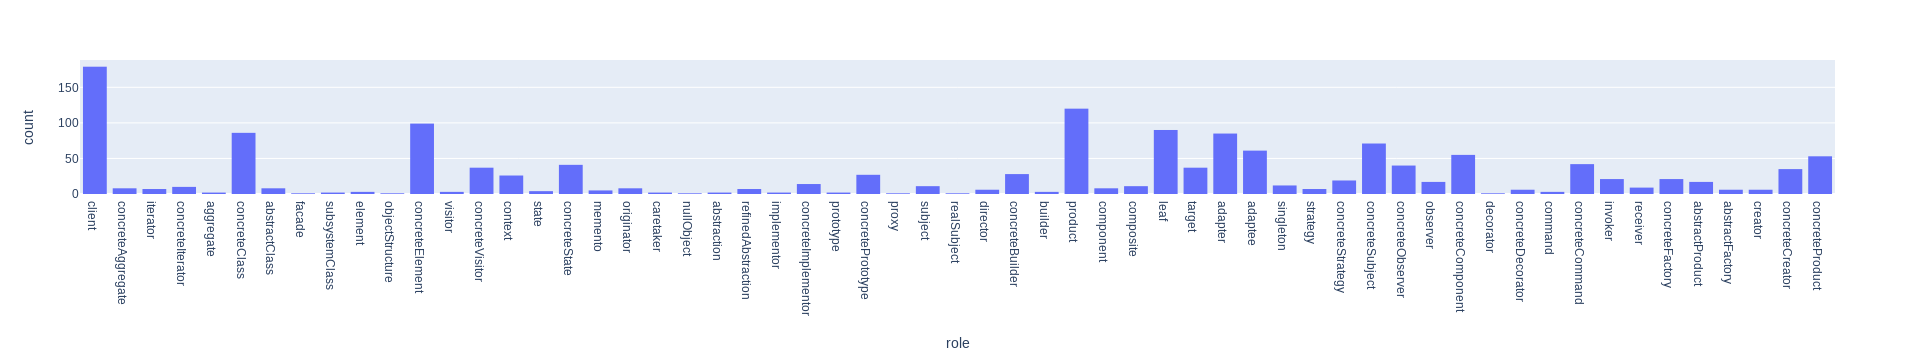

In [165]:
px.histogram(df, x='role', histfunc='count')

### Distribution of desgin patterns

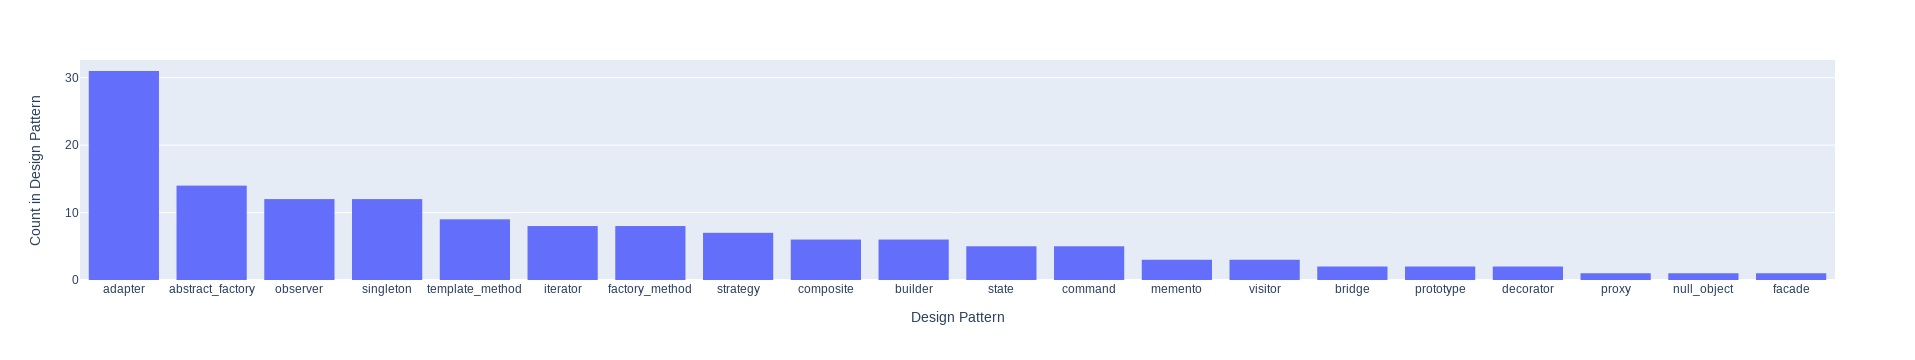

In [161]:
df_binned_by_micro_arch_dp = df.copy()
df_binned_by_micro_arch_dp = df_binned_by_micro_arch_dp.drop_duplicates(['micro_architecture', 'design_pattern']).reset_index()
df_binned_by_micro_arch_dp = df_binned_by_micro_arch_dp['design_pattern'].value_counts().reset_index()

fig = px.histogram(df_binned_by_micro_arch_dp, x='design_pattern', y='count')
fig.update_layout(xaxis_title='Design Pattern', yaxis_title='Count in Design Pattern')

### Distribution for metrics

In [162]:
def initial_histogram():
    return go.Histogram(
        histfunc='count',
    )

def update_histogram(figure: go.Figure, df: pd.DataFrame, metric: str):
    figure['x'] = df[metric]

generate_selectable_graph_for_metrircs(df, initial_histogram, update_histogram, 'count')

### Box Plots for metrics

In [163]:
def initial_histogram():
    return go.Box(
    )

def update_histogram(figure: go.Figure, df: pd.DataFrame, metric: str):
    figure['x'] = df[metric]

generate_selectable_graph_for_metrircs(df, initial_histogram, update_histogram)